In [1]:
import numpy as np
import cv2 as cv
import pandas as pd

from sklearn.cluster import KMeans, k_means
from scipy.optimize import linear_sum_assignment
from scipy.spatial import distance_matrix

from os.path import join
from itertools import count
from functools import partial

import matplotlib.pyplot as plt

In [2]:
def construct_undistort_map(image_size, folder):
    """ Construct openCV undistort undistort mapping. Make sure files as named below are the supplied folder.
    Returns a function which takes in image and returns the undistorted image."""
    mtx = np.load(join(folder, "mtx_file.npy"))
    dist = np.load(join(folder, "dist_file.npy"))
    newcameramtx = np.load(join(folder, "newcameramtx_file.npy"))

    mapping = cv.initUndistortRectifyMap(mtx, dist, None, newcameramtx, image_size, 5)
    return mapping

In [3]:
def default_blob_detector_params():
    """Blob detector params used to perform initial localization."""
    # Setup SimpleBlobDetector parameters.
    params = cv.SimpleBlobDetector_Params()

    # Change thresholds
    params.minThreshold = 20
    params.maxThreshold = 150

    # Filter by Area.
    params.filterByArea = True
    params.minArea = 15
    params.maxArea = 60
    params.minDistBetweenBlobs = 1.0

    # Turn off other filters
    params.filterByCircularity = False
    params.filterByConvexity = False
    params.filterByInertia = False

    return params

In [4]:
def preprocessing(image, mapping, mask):
    """Preprocesses image to make it ready for kmeans."""
    processed_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    processed_image = cv.remap(processed_image, *mapping, cv.INTER_LINEAR)
    processed_image[~mask] = 255
    return processed_image

In [5]:
def blob_detector_localization(image):
    """Find flies using blob detector"""
    blob_detector = cv.SimpleBlobDetector_create(default_blob_detector_params())
    keypoints = blob_detector.detect(image)  # get keypoints
    return np.array([keypoint.pt for keypoint in keypoints])

def localize_kmeans(image, init, threshold=120):
    """Find flies using kmeans."""
    n_flies = init.shape[0]
    fly_pixels = cv.findNonZero((image < threshold).astype("uint8")).squeeze()
    locations = KMeans(n_clusters=n_flies, n_init=1, init=init).fit(fly_pixels).cluster_centers_
    return locations

def hungarian(locs_new, locs_prev):
    """Returns ordered fly location (i.e. tracks)"""
    new_ordering = linear_sum_assignment(distance_matrix(locs_new, locs_prev))[1]
    return locs_new[new_ordering]

In [6]:
def initialize(loader, n_frames):
    """Find flies using blob detector and
    calulate number of flies."""
    n_blobs = []
    for frame_idx in count():
        image = loader()
        locations = blob_detector_localization(image)
        n_blobs.append(locations.shape[0])

        if len(n_blobs) >= n_frames:
            n_flies = int(np.median(n_blobs))
            if (n_blobs[-1] == n_flies):
                break

    return n_flies, locations, frame_idx

def localize(loader, initial_position, n_frames=None):
    "Track flies using kmeans"
    locations = [initial_position]
    for idx in count():
        try:
            image = loader()
        except:
            break # finished
        
        locations.append(hungarian(localize_kmeans(image, locations[-1]), locations[-1]))
        
        if idx % 1000 == 0:
            print(f"Done with frame {idx}")
        if idx + 1 == n_frames:
            break # max number of frames
    return locations

In [7]:
def post_process(locations, initial_frame, n_arenas):
    """ Post processing: turns into dataframe, sorts per arena."""
    n_frames = len(locations)
    n_flies = len(locations[0])
    identities = (
        np.arange(n_flies)[None, :] * np.ones((n_frames, n_flies))
    ).reshape(
        -1, 1
    )  # we get free tracking from the kmeans
    frames = (
        np.arange(initial_frame, n_frames + initial_frame)[:, None]
        * np.ones((n_frames, n_flies))
    ).reshape(-1, 1)
    df = pd.DataFrame(
        np.concatenate(
            [frames, identities, np.concatenate(locations, axis=0)], axis=1
        ),
        columns=["frame", "ID", "x", "y"],
    )

    # Localizing flies per arena
    x_ave = df.pivot_table(index="ID", columns="frame", values="x").mean(axis=1)
    y_ave = df.pivot_table(index="ID", columns="frame", values="y").mean(axis=1)
    labels = k_means(np.stack([x_ave, y_ave], axis=1), n_arenas)[1]
    df["arena"] = (labels[None, :] * np.ones((df.frame.unique().size, 1))).flatten()
    return df

In [8]:
def run(movie_path, mask, n_arenas, mapping_folder, n_frames=None, n_ini=100):
    """Runs the whole pipeline. I.e preprocessing, localizing and postprocessing."""
    # Constructing loader
    capture = cv.VideoCapture(movie_path)


    image_size = (
            int(capture.get(cv.CAP_PROP_FRAME_WIDTH)),
            int(capture.get(cv.CAP_PROP_FRAME_HEIGHT)),
        )
    mapping = construct_undistort_map(image_size, mapping_folder)

    loader = lambda: preprocessing(capture.read()[1], mapping=mapping, mask=mask)
    
    # Actual logic
    n_flies, initial_locations, initial_frame = initialize(loader, n_ini)
    locs = localize(loader, initial_locations, n_frames=n_frames)
    df = post_process(locs, initial_frame, n_arenas=n_arenas)
    return df

In [9]:
# Making mask
movie_path = "/home/gert-jan/Documents/flyTracker/data/testing_data/4arenas/seq_1.h264"
mapping_folder = "/home/gert-jan/Documents/flyTracker/data/distortion_maps/"

capture = cv.VideoCapture(movie_path)
image_size = (
        int(capture.get(cv.CAP_PROP_FRAME_WIDTH)),
        int(capture.get(cv.CAP_PROP_FRAME_HEIGHT)),
    )
mapping = construct_undistort_map(image_size, mapping_folder)
image = lambda mask: preprocessing(capture.read()[1], mapping=mapping, mask=mask)

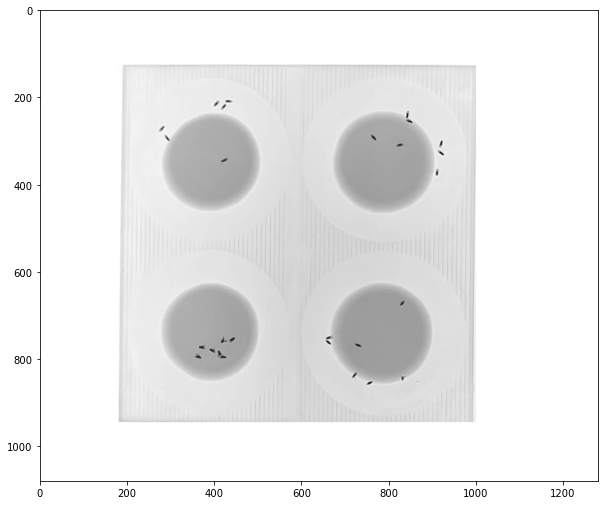

In [10]:
# Creating mask
mask = mask=np.ones(image_size, dtype=bool).T
mask[:125, :] = 0
mask[-135:, :] = 0
mask[:, :180] = 0
mask[:, -280:] = 0


plt.figure(figsize=(10, 10))
plt.imshow(image(mask), cmap='gray')

In [11]:
%%time
# If mask looks good, run it for 1000 frames as an extra check; timing should give you an idea how long it should take.
movie_path = "/home/gert-jan/Documents/flyTracker/data/testing_data/4arenas/seq_1.h264"
mapping_folder = "/home/gert-jan/Documents/flyTracker/data/distortion_maps/"
df = run(movie_path, mask, n_arenas=4, mapping_folder=mapping_folder, n_frames=1000)
df.to_hdf('df_new.hdf', key='df', complevel=9, complib='blosc')

Done with frame 0
CPU times: user 2min 38s, sys: 23.5 s, total: 3min 1s
Wall time: 8.08 s


In [12]:
# If everything is still good, run the whole thing
movie_path = "/home/gert-jan/Documents/flyTracker/data/testing_data/4arenas/seq_1.h264"
mapping_folder = "/home/gert-jan/Documents/flyTracker/data/distortion_maps/"
df = run(movie_path, mask, n_arenas=4, mapping_folder=mapping_folder)
df.to_hdf('df_new.hdf', key='df', complevel=9, complib='blosc')

Done with frame 0
Done with frame 1000
Done with frame 2000
Done with frame 3000
Done with frame 4000
Done with frame 5000
Done with frame 6000
Done with frame 7000
Done with frame 8000
Done with frame 9000
Done with frame 10000
Done with frame 11000
Done with frame 12000
Done with frame 13000
Done with frame 14000
Done with frame 15000
Done with frame 16000
Done with frame 17000
Done with frame 18000
Done with frame 19000
Done with frame 20000
Done with frame 21000
Done with frame 22000
Done with frame 23000
Done with frame 24000
Done with frame 25000
Done with frame 26000
Done with frame 27000
Done with frame 28000
Done with frame 29000
Done with frame 30000
Done with frame 31000
Done with frame 32000
Done with frame 33000
Done with frame 34000
Done with frame 35000
Done with frame 36000
Done with frame 37000
Done with frame 38000
Done with frame 39000
Done with frame 40000
Done with frame 41000
Done with frame 42000
Done with frame 43000
Done with frame 44000
Done with frame 45000
D